In [40]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [41]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

# import my_secrets as sc
# import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE

import pandas as pd

## Notebook overview

*Previous notebook: baseline*

*Next notebook: none, last notebook*

## Page distribution

In [50]:
txtfiles = pd.read_pickle(f"{cf.output_path}/txtfiles.pkl")
notcleaned = pd.read_pickle(f"{cf.output_path}/txtfiles_notcleaned.pkl")

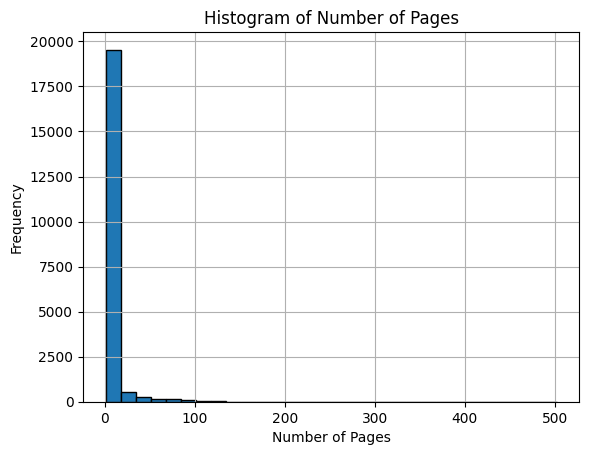

In [43]:
import matplotlib.pyplot as plt

# Assuming txtfiles is your DataFrame and num_pages is the column you want to plot
plt.hist(txtfiles['num_pages'], bins=30, edgecolor='black')  # Adjust number of bins as needed
plt.xlabel('Number of Pages')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Pages')
plt.grid(True)
plt.show()


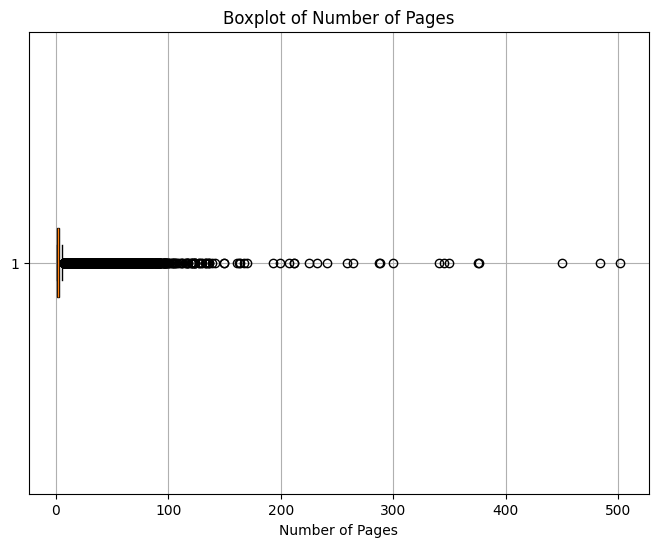

In [44]:
import matplotlib.pyplot as plt

# Assuming txtfiles is your DataFrame and num_pages is the column you want to plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.boxplot(txtfiles['num_pages'], vert=False, patch_artist=True)
plt.xlabel('Number of Pages')
plt.title('Boxplot of Number of Pages')
plt.grid(True)
plt.show()


In [55]:
cleaned = notcleaned.loc[notcleaned['id'].isin(txtfiles['id'])]

notcleaned_removed = notcleaned.loc[~notcleaned['label'].isin(['Adviesaanvraag', 'Amendement', 'Begroting'])]

display(notcleaned_removed['token_count'].describe())
display(notcleaned_removed['num_pages'].describe())
display(cleaned['token_count'].describe())
display(cleaned['num_pages'].describe())


count     26739.000000
mean       2019.839298
std        6980.052643
min           3.000000
25%         291.000000
50%         516.000000
75%        1160.000000
max      275597.000000
Name: token_count, dtype: float64

count    26737.000000
mean         5.420541
std         14.832611
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max        502.000000
Name: num_pages, dtype: float64

count     20818.000000
mean       2120.675617
std        7545.434859
min          20.000000
25%         271.250000
50%         455.000000
75%        1106.000000
max      275597.000000
Name: token_count, dtype: float64

count    20818.000000
mean         5.604381
std         16.089036
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        502.000000
Name: num_pages, dtype: float64

In [48]:
txtfiles.columns

Index(['label', 'path', 'id', 'text', 'num_pages', '4split', '2split',
       'MistralTokens', 'count_MistralTokens', 'LlamaTokens',
       'count_LlamaTokens', 'md5_hash', 'balanced_split'],
      dtype='object')

In [49]:
cleaned = 
display(txtfiles['count_LlamaTokens'].describe())

notcleaned = notcleaned.loc[~notcleaned['label'].isin(['Adviesaanvraag', 'Amendement', 'Begroting'])]

display(notcleaned['count_LlamaTokens'].describe())

count     20818.000000
mean       4340.207897
std       15456.312555
min          74.000000
25%         612.000000
50%        1031.000000
75%        2378.000000
max      618067.000000
Name: count_LlamaTokens, dtype: float64

KeyError: 'count_LlamaTokens'

### Amount of docs exceeding limit

In [7]:
print(list(txtfiles.columns))

['label', 'path', 'id', 'text', 'num_pages', '4split', '2split', 'MistralTokens', 'count_MistralTokens', 'LlamaTokens', 'count_LlamaTokens', 'md5_hash', 'balanced_split']


In [8]:
print(len(txtfiles.loc[txtfiles['count_LlamaTokens']>4096])/len(txtfiles))

0.1343548851955039


### Baseline experiment

## Fine-tuning Experiments
- Accuracy scores for each model, and epoch
- Runtime per doc for each model, and 

In [6]:
def average_runtime_per_doc(runtime):
    return round(runtime/1100)

In [7]:

# incontext learing -> training on 0 epochs is the same as incontext learning
epoch0_g = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/overview.pkl")
epoch0_g = epoch0_g.loc[epoch0_g['run_id']=='IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0']
epoch0_l = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/overview.pkl")
epoch0_l = epoch0_l.loc[epoch0_l['run_id']=='IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0']
epoch0_m = pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/overview.pkl")
epoch0_m = epoch0_m.loc[epoch0_m['run_id']=='IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0']
epoch0 = pd.concat([epoch0_g, epoch0_l, epoch0_m])
epoch0['base_model'] = ['GEITje', 'Llama', 'Mistral']
epoch0['epoch'] = 0

#fine-tuning
epoch1 = pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/1epochs/overview.pkl")
epoch1['base_model'] = ['Mistral', 'GEITje', 'Llama']
epoch1['epoch'] = 1
epoch2 = pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/2epochs/overview.pkl")
epoch2 = epoch2.loc[epoch2['model']!='AmsterdamDocClassificationMistral200T2Epochs']
# epoch2 = epoch2.drop(index=3)
epoch2['epoch'] = 2
epoch2['base_model'] = ['GEITje', 'Llama', 'Mistral']
# display(epoch2)

epoch3 = pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/3epochs/overview.pkl")
epoch3 = epoch3.loc[epoch3['model']!='AmsterdamDocClassificationMistral200T3Epochs']
# epoch3 = epoch3.drop(index=3)
epoch3['base_model'] = ['Llama', 'GEITje', 'Mistral']
epoch3['epoch'] = 3
# display(epoch3)


overview = pd.concat([epoch0, epoch1, epoch2, epoch3])
overview['runtime_per_doc'] = overview['runtime'].apply(average_runtime_per_doc)
# display(overview)

# geitje_overview = overview.

In [8]:
# colors = ['#0099B4B2', '#AA4499', '#7AD151FF']
# colors = ['#9B1003', '#7AD151FF',  '#0099B4B2']
colors = ['#2093c3', '#FCD12A',  '#9B1003']

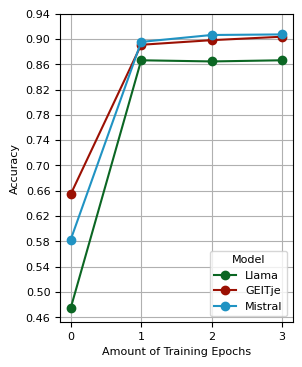

In [35]:
import matplotlib.pyplot as plt

colors = ['#0B6623', '#9B1003',  '#2093c3']

plt.figure(figsize=(3, 4))
df = overview.copy()
# Loop through each model and plot
for idx, model in enumerate(df['base_model'].unique()):
    model_df = df[df['base_model'] == model]
    plt.plot(model_df['epoch'], model_df['accuracy'], marker='o', label=model, color=colors[idx % len(colors)])

    # for i, acc in enumerate(model_df['accuracy']):
    #     plt.text(model_df['epoch'].iloc[i], acc, f'{acc:.3f}', ha='center', va='bottom')


fs = 8
plt.xticks([0,1, 2, 3],fontsize=fs)
steps = [round(0.46 + i * 0.04, 2) for i in range(int((0.92 - 0.44) / 0.04) + 1)]
plt.yticks(steps, fontsize=fs)
plt.xlabel('Amount of Training Epochs', fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
# plt.title('Model Accuracy Over Epochs')
plt.legend(title='Model', fontsize=fs, title_fontsize=fs)
plt.rc('legend', fontsize=fs)

plt.grid(True)
plt.show()

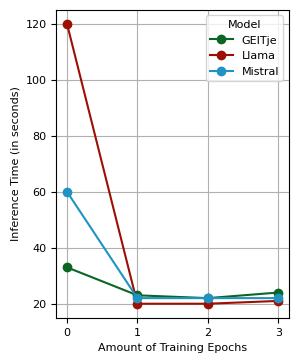

In [10]:
import matplotlib.pyplot as plt
colors = ['#0B6623', '#9B1003',  '#2093c3']



plt.figure(figsize=(3, 4))
df = overview.copy()
# Loop through each model and plot
for idx, model in enumerate(df['base_model'].unique()):
    model_df = df[df['base_model'] == model]
    plt.plot(model_df['epoch'], model_df['runtime_per_doc'], marker='o', label=model, color=colors[idx % len(colors)])

    # for i, rt in enumerate(model_df['runtime_per_doc']):
    #     plt.text(model_df['epoch'].iloc[i], rt, f'{rt}', ha='center', va='bottom')


fs = 8
plt.xticks([0,1, 2, 3],fontsize=fs)
steps = [round(20 + i * 20, 2) for i in range(int((120 - 20) / 20) + 1)]
plt.yticks(steps, fontsize=fs)
plt.xlabel('Amount of Training Epochs', fontsize=fs)
plt.ylabel('Inference Time (in seconds)', fontsize=fs)
# plt.title('Model Accuracy Over Epochs')
plt.legend(title='Model', fontsize=fs, title_fontsize=fs)
plt.rc('legend', fontsize=fs)

plt.grid(True)
plt.show()


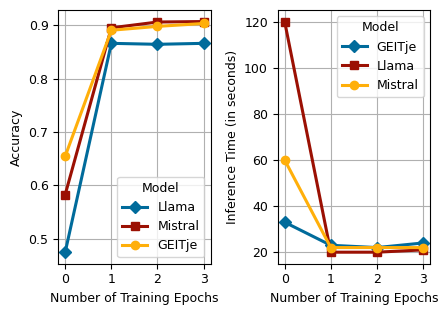

In [39]:
import matplotlib.pyplot as plt

# First plot
plt.figure(figsize=(4.5, 3.25))  # Adjust figsize as needed
# colors = ['#0B6623', '#9B1003', '#2093c3']

colors = ['#008080', '#00BFFF', '#FF4500']
colors = ['#D81B60', '#1E88E5', '#FFC107']
colors = ['#000373',  '#FFB000' ,  "#E64B89" ]
colors = ['#006B9B', '#9B1003',  '#FFAF0A']

markers = ['D', 's', 'o']  # Square, Star, Diamond
marker_size = 14
line_width = 2.2


plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, position 1
df = overview.copy()
# for idx, model in enumerate(df['base_model'].unique()):
for idx, model in enumerate(['Llama', 'Mistral', 'GEITje']):

    model_df = df[df['base_model'] == model]
    plt.plot(model_df['epoch'], model_df['accuracy'], marker=markers[idx], label=model, color=colors[idx % len(colors)], linewidth=line_width)

fs = 9
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks([0,1, 2, 3],fontsize=fs)
plt.xlabel('Number of Training Epochs', fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
plt.legend(title='Model', fontsize=fs, title_fontsize=fs)
plt.grid(True)

# Second plot
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, position 2
df = overview.copy()
for idx, model in enumerate(df['base_model'].unique()):
    model_df = df[df['base_model'] == model]
    plt.plot(model_df['epoch'], model_df['runtime_per_doc'], marker=markers[idx], label=model, color=colors[idx % len(colors)], linewidth=line_width)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks([0,1, 2, 3],fontsize=fs)
plt.xlabel('Number of Training Epochs', fontsize=fs)
plt.ylabel('Inference Time (in seconds)', fontsize=fs)
plt.legend(title='Model', fontsize=fs, title_fontsize=fs)
plt.grid(True)

plt.tight_layout()  # Ensures plots are nicely spaced
plt.show()


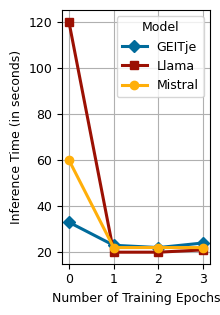

In [28]:
# Second plot

# plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, position 2
df = overview.copy()
plt.figure(figsize=(2.3, 3.25))  # Adjust figsize as needed

for idx, model in enumerate(df['base_model'].unique()):
    model_df = df[df['base_model'] == model]
    plt.plot(model_df['epoch'], model_df['runtime_per_doc'], marker=markers[idx], label=model, color=colors[idx % len(colors)], linewidth=line_width)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks([0,1, 2, 3],fontsize=fs)
plt.xlabel('Number of Training Epochs', fontsize=fs)
plt.ylabel('Inference Time (in seconds)', fontsize=fs)
plt.legend(title='Model', fontsize=fs, title_fontsize=fs)
plt.grid(True)

plt.tight_layout()  # Ensures plots are nicely spaced
plt.show()